# Zmęczenie i Diagnostyka Konstrukcji Lotniczych

Nowa wersja programu która nie wymaga samodzielnego programowania grafiki - to faktycznie warto polecać do użytku przez inżynierów.

## Ustawienie środowiska

Importowane są potrzebne biblioteki, ustawiany rozmiar wykresów.

Funkcje `round_numbers`, `tex` oraz `md` ułatwiają wyświetlanie równań.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(13, 7))
from IPython.display import display, Markdown, Latex  # Display cells with dynamic content
from string import Template  # Replace text with $ instead of {}, much better for LaTeX equations

def round_numbers(data: dict, places: int) -> dict:
  """Setup floating point variables for string substitution

  Parameters
  ----------
  data : dict
      A dictionary of values with string keys
  places : int
      Number of decimal places in string representation

  Returns
  -------
  dict
      A copy of `data` with floats converted to strings
  """
  format_string = '{:.' + str(places) + 'f}'
  result = dict()
  for k, v in data.items():
    if isinstance(v, float):
      result[k] = format_string.format(v)
    else:
      result[k] = v
  return result

tex = lambda text, data, places = 3: display(Latex(Template(text).substitute(round_numbers(data, places))))
md = lambda text, data, places = 3: display(Markdown(Template(text).substitute(round_numbers(data, places))))

## Filtrowanie danych
W zmiennej `data` podana jest lista punktów, funkcja `only_extremes` usuwa punkty które nie są ekstremami. Zmienna `numlevels` będzie potem potrzebna do wyświetlania tabel.

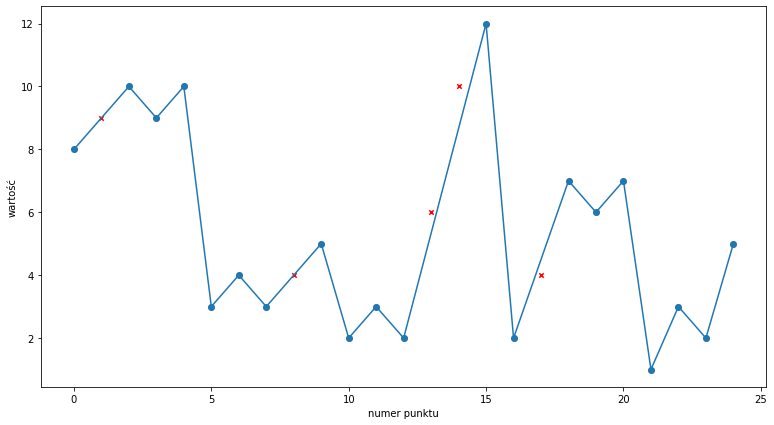

In [2]:
numlevels = 12
data = [8, 9, 10, 9, 10, 3, 4, 3, 4, 5, 2, 3, 2, 6, 10, 12, 2, 4, 7, 6, 7, 1, 3, 2, 5]

def only_extremes(l: list) -> list:
  extremes = [l[0]]
  indices = [0]
  for i, n in enumerate(l[:-1]):
    back = l[i -1] - n
    front = l[i+1] - n
    if back == 0:
      continue
    if back * front < 0:
      continue
    extremes.append(n)
    indices.append(i)

  extremes.append(l[-1])
  indices.append(len(l) - 1)

  return indices, extremes

i, e = only_extremes(data)
plt.scatter(np.arange(len(data)), data, marker='x', s=20, c='red')
plt.plot(i, e)
plt.scatter(i, e)
plt.ylabel('wartość')
plt.xlabel('numer punktu')
plt.show()

data = e

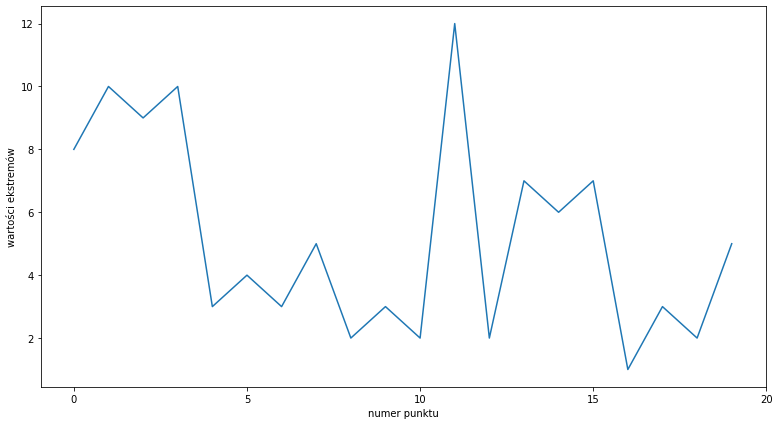

In [3]:
plt.plot(data)
plt.ylabel('wartości ekstremów')
plt.xlabel('numer punktu')
plt.xticks([0, 5, 10, 15, 20])
plt.show()

## Tablica przejść

Zliczanie ile razy wystąpiło przejście pomiędzy konkretnymi dwoma stanami.

In [4]:
transfers = []
for i, d in enumerate(data[:-1]):
  transfers.append((d, data[i+1]))

transfer_counts = {}
for t in transfers:
  if t in transfer_counts:
    transfer_counts[t] += 1
  else:
    transfer_counts[t] = 1

In [5]:
table_rows = [ '| Z \\ Do | &nbsp;&nbsp;&nbsp;&nbsp;' + ' | &nbsp;&nbsp;&nbsp;&nbsp;'.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif (m+1, n+1) in transfer_counts:
      row += ' ' + str(transfer_counts[(m+1, n+1)]) + '|'
    else:
      row += ' |'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| Z \ Do | &nbsp;&nbsp;&nbsp;&nbsp;1 | &nbsp;&nbsp;&nbsp;&nbsp;2 | &nbsp;&nbsp;&nbsp;&nbsp;3 | &nbsp;&nbsp;&nbsp;&nbsp;4 | &nbsp;&nbsp;&nbsp;&nbsp;5 | &nbsp;&nbsp;&nbsp;&nbsp;6 | &nbsp;&nbsp;&nbsp;&nbsp;7 | &nbsp;&nbsp;&nbsp;&nbsp;8 | &nbsp;&nbsp;&nbsp;&nbsp;9 | &nbsp;&nbsp;&nbsp;&nbsp;10 | &nbsp;&nbsp;&nbsp;&nbsp;11 | &nbsp;&nbsp;&nbsp;&nbsp;12
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **12** | | 1| | | | | | | | | | X |
| **11** | | | | | | | | | | | X | |
| **10** | | | 1| | | | | | 1| X | | |
| **9** | | | | | | | | | X | 1| | |
| **8** | | | | | | | | X | | 1| | |
| **7** | 1| | | | | 1| X | | | | | |
| **6** | | | | | | X | 1| | | | | |
| **5** | | 1| | | X | | | | | | | |
| **4** | | | 1| X | | | | | | | | |
| **3** | | 2| X | 1| 1| | | | | | | |
| **2** | | X | 1| | 1| | 1| | | | | 1|
| **1** | X | | 1| | | | | | | | | |

### Rysowanie tablic

| Kolumna 1 | Kolumna 2 | Kolumna 3 |
| :-- | :-: | --: |
| Rząd 1 | środek | do prawej |
| Rząd 2 | **pogrubiony** | *kursywa* |

Definicja tabeli jest w formie tekstowej, w drugiej linijce ustalone jest wyrównanie tekstu w kolumnach

```
| Kolumna 1 | Kolumna 2      | Kolumna 3 |
| :--       | :-:            | --:       |
| Rząd 1    | środek         | do prawej |
| Rząd 2    | **pogrubiony** | *kursywa* |
```

## Zliczanie półcykli

Następujący fragment kodu symuluje "kropelki" spływające od lewej po wykresie. Dla każdej zapisywane są punkty przez które przepływa, oraz dodawane do listy `taken_peaks`. Dzięki temu w kolejnych iteracjach można wykryć które z ekstremów już były oznaczone i przerwać wskutek "kolizji" z jednym z poprzedzających półcykli.

In [6]:
from math import copysign
sign = lambda x: copysign(1, x)

def make_droplets(data: list, direction: int) -> list:
  assert direction != 0
  direction = sign(direction)
  droplets = []
  taken_peaks = []
  for i, start in enumerate(data[:-1]):
    if sign(data[i + 1] - start) == direction:
      drop = { 'from': start, 'points': [(i, start)]}
      current_d = start
      for j in range(i+1, len(data)):
        if (data[j] - current_d) * direction >= 0:  # Fall on the next line
          taken_index = next((i for i, x in enumerate(taken_peaks) if x['index'] == j), -1)
          old_intercept = taken_peaks[taken_index]['intercept'] if taken_index != -1 else np.NaN

          if len(drop['points']) > 1:
            # Move the last point to intercept this roof nicely
            intercept_delta_x = (current_d - data[j-1]) / (data[j] - data[j-1])
            drop['points'][-1] = (drop['points'][-1][0] + intercept_delta_x, drop['points'][-1][1])
            # Store all interceptions to allow checking for collisons
            if taken_index == -1:
               taken_peaks.append({'index': j, 'intercept': current_d})
            else:
              taken_peaks[taken_index] = { 'index': j, 'intercept': current_d}

          if taken_index != -1:
            lerp_arg = ((old_intercept - direction * 0.2) - data[j-1]) / (data[j] - data[j-1])
            
            drop['points'].append((j-1+ lerp_arg, data[j-1] + lerp_arg * (data[j] - data[j-1])))
            drop['to'] = old_intercept
            break

          drop['points'].append((j, data[j]))
          current_d = data[j]

        else:
          drop['points'].append((j, current_d))  # Fall down straight

          if (data[j] - drop['from']) * direction < 0:  # Termination condition
            drop['to'] = current_d
            break

        if j == len(data) - 1:  # Extend beyond last point
          drop['points'].append((j + 1, current_d))
          drop['to'] = current_d

      droplets.append(drop)
  return droplets

Żeby poprawić czytelność wykresu, obliczone półcykle są rysowane nieco przesunięte względem oryginalnych danych.

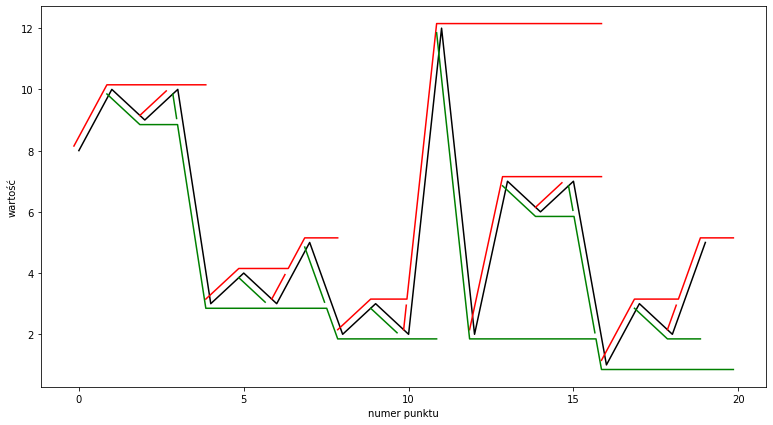

In [7]:
plt.plot(data, c='black')

drops_top = make_droplets(data, 1)
for drop in drops_top:
  points = np.array(drop['points'])
  # Offset diagonally by a small value to display next to original data
  points = points + np.tile(np.array([-0.15, 0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='red')

drops_bottom = make_droplets(data, -1)
for drop in drops_bottom:
  points = np.array(drop['points'])
  points = points + np.tile(np.array([-0.15, -0.15]), (points.shape[0], 1))
  plt.plot(points[:,0], points[:,1], c='green')

plt.ylabel('wartość')
plt.xlabel('numer punktu')
plt.xticks([0, 5, 10, 15, 20])
plt.show()

Zliczanie półcykli i wyświetlanie w tabeli odbywa się tak samo jak przejść. Półcykle dla których wystąpił przynajmniej jeden cykl obciążenia są wyróżnione w tabeli kwadratowymi nawiasami: [N]

In [8]:
drops_all = drops_top + drops_bottom
halfcycle_counts = {}
for d in drops_all:
  t = (d['from'], d['to'])
  if t in halfcycle_counts:
    halfcycle_counts[t] += 1
  else:
    halfcycle_counts[t] = 1

In [9]:
table_rows = [ '| Z \\ Do | &nbsp;&nbsp;&nbsp;&nbsp;' + ' | &nbsp;&nbsp;&nbsp;&nbsp;'.join([str(n + 1) for n in range(numlevels)]),
'| --: '*(numlevels + 1) + '|' ]
for m in reversed(range(numlevels)):
  row = '| **' + str(m+1) + '** |'
  for n in range(numlevels):
    if m == n:
      row += ' X |'
    elif (m+1, n+1) in halfcycle_counts:
      if (n+1, m+1) in halfcycle_counts:
        row += ' [' + str(halfcycle_counts[(m+1, n+1)]) + ']|'
      else:
        row += ' ' + str(halfcycle_counts[(m+1, n+1)]) + '|'
    else:
      row += ' |'
  table_rows.append(row)

table = '\n'.join(table_rows)
display(Markdown(table))

| Z \ Do | &nbsp;&nbsp;&nbsp;&nbsp;1 | &nbsp;&nbsp;&nbsp;&nbsp;2 | &nbsp;&nbsp;&nbsp;&nbsp;3 | &nbsp;&nbsp;&nbsp;&nbsp;4 | &nbsp;&nbsp;&nbsp;&nbsp;5 | &nbsp;&nbsp;&nbsp;&nbsp;6 | &nbsp;&nbsp;&nbsp;&nbsp;7 | &nbsp;&nbsp;&nbsp;&nbsp;8 | &nbsp;&nbsp;&nbsp;&nbsp;9 | &nbsp;&nbsp;&nbsp;&nbsp;10 | &nbsp;&nbsp;&nbsp;&nbsp;11 | &nbsp;&nbsp;&nbsp;&nbsp;12
| --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| **12** | 1| | | | | | | | | | | X |
| **11** | | | | | | | | | | | X | |
| **10** | | 1| | | | | | | [1]| X | | |
| **9** | | | | | | | | | X | [1]| | |
| **8** | | | | | | | | X | | 1| | |
| **7** | | [1]| | | | [1]| X | | | | | |
| **6** | | | | | | X | [1]| | | | | |
| **5** | | | [1]| | X | | | | | | | |
| **4** | | | [1]| X | | | | | | | | |
| **3** | | [2]| X | [1]| [1]| | | | | | | |
| **2** | | X | [2]| | | | [1]| | | | | 1|
| **1** | X | | | | 1| | | | | | | |

## Sprawdzenie liczby punktów

Liczba przejść oraz wszystkich półcykli (w stronę większego i mniejszego obciążenia) powinny być równe.

$$ N - 1 = \sum{\Delta LL_{TA}} = \sum{\Delta LL_{top}} + \sum{\Delta LL_{bottom}} $$

In [10]:
num = {
  'n': len(data),
  'llta': len(transfers),
  'lltop': len(drops_top),
  'llbottom': len(drops_bottom)
}
tex(r'$$$$ $n - 1 = $llta = $lltop + $llbottom $$$$', num)

<IPython.core.display.Latex object>